# Exploratory Data Analysis

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from summarytools import dfSummary

from env_setup import *
from functions.t_test import *

pd.set_option('display.max_columns', None)

In [2]:
# Load data
df_raw = pd.read_csv(datachurn)
df_raw.head()
df_ori = df_raw.copy()

## 2. EDA
### 2.1. Data quality checks
- No duplicates
- Dataset imbalanced. Churned 28.1% vs 71.9%
- `TransactionDate` to be converted to integer

In [3]:
# Extract days from TransactionDate
df_ori['TransactionDate'] = df_ori['TransactionDate'].str.extract(r"([0-9]+)").astype(int)

In [4]:
# View summaries
dfSummary(df_ori)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CustomerID[int64],Mean (sd) : 49973.7 (28875.3)min < med < max:1.0 < 49977.0 < 100000.0IQR (CV) : 50008.0 (1.7),"100,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACZklEQVR4nO3Yva/SUBjH8ecA9+bwYhtehK2Lo4kDCQuLm6N/rKsjCSTODC5OLISEQAn1EhrE4eoKtPVSf/r9zH162pPvKQnufD4b8LerlP0AwC1q1y5wztXN7DHn/Y/n8/kp5+x/qeB+m/2je34xVOdcvdvtfgyCoJ3n5tvtdu+c+2xmh1xP9/zF/1HCbFlr+06n8yEMw2bOdW23222cc5/yxPoHDkmRPbt4wK59UR+DIGiPx+OnMAwzxbZcLl/NZrP3URT1qtVq5lBPp9NDkiRvWq3Wt0qlkt5rtsy10zT1ZvZ2NBp96fV6u0wPbWZxHPvJZNJfr9c951zW+UKHpOieXztgV3/6zczCMDz0+/3vWRbebDZ1731jOBweBoPBJsusmdlisWjP5/PXw+Hwa9b5IrNlrv1rtuG9T7Put5lZkiQPaZq+i6KomvXjUPSQFHnvOI79dDptr9frRzPLH2oRzWYzc+Rmz6HnnS8yW+bav2fzOh6Ptbwfh6KHpOiem9nFd3/xUHF/ZRySl8bfU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBQu+WiOI591hvv93tvZpYkiV+tVo17zquurfrcRedv6esnVqVCl4UsRRAAAAAASUVORK5CYII="">",0(0.0%)
2,Age[int64],Mean (sd) : 43.5 (15.0)min < med < max:18.0 < 43.0 < 69.0IQR (CV) : 25.0 (2.9),52 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACq0lEQVR4nO3ZsU8aYRjH8ecF0Rehd0EpbiwdTTqQuLB0c+wf27WbgyadGbp0cjEm5oRwlXAedKimQxPh3vOAH/l+Zh7e986voPe65XJpwK6rbXsDwDoOVr3AOdc0s8PA958vl8unwFmIqbKVN0N1zjVPT0+/RlHUCVl5MpkkzrlvxLr/qm5l1SfqYRRFneFw+BTH8azIwuPx2F9fX3ceHh4OzYxQ91+lraz86jczi+N41uv1fhdZ/EUzYAbCqmqFf6YggVAhgVAhgVAhgVAhgVAhYa3HU4pKnpKY/f0lXgTObu1Ebl9PEnc61BI33Z+cnFzGcdwKWTfP80aapp/a7favWq2WFZ1/fHycOue+m1mhB98vgmMpezpUct/RYrFohKy7jkpDzfO8YWaRcy5kPDi2LMu8mZ1fXFz86Ha7k6Lzt7e3ndFo9HEwGPw8OztLisze3d19uLm5+dLv97v1er3wD7xsLO12uzccDidFT4fK7jvLMp/n+flsNrsys5AH/m+qLNQ0TRtZln3u9/v10Au3wNheQjv23mchpyRJkjTNzFqtVuFTliRJmt7748FgMNt05K+xHB0dXW1y32b/7vnz83O96Ow6Kgt1Pp8fvMeFh8T2Gto2bTpys/eJJWTfZtXf88r/Rt3VC99l3LP/8XgKEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEg7WedF4PPZF33g6nXozszRN/f39/fEm51XXVt132fl1+voDIipWFKKxhGsAAAAASUVORK5CYII="">",0(0.0%)
3,Gender[object],1. Female2. Male,"501,230 (50.2%)496,401 (49.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
4,Income[int64],Mean (sd) : 60189.7 (23043.0)min < med < max:20000.0 < 60262.0 < 99999.0IQR (CV) : 39679.0 (2.6),"57,178 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACgUlEQVR4nO3Yv2/aQBiH8fcgCUegtvhRsrF0jNQBiYWlW8f+sV27FQmkzgxdOrEgJAuMcIMwlA5VpUwE27Tki57PzMsd+OEMuMPhYMBrV7r0BoBT3Fx6Azgv51zVzO5yjm8Ph8PTOfdzLoR6RZxz1Var9SkIgkae+dVqtXDOfX6NsV5tqAVPFrM/X4t+ic0G9Xq9MxgMVmEYbrIMxnHsh8NhJ4qitnNulXP9Ins/epq/GOolbyUF1vbNZvNjGIa1POvu9/vbJEne1ev1H6VSKVWYNTNL09Tv9/vHSqXytdPp/MwymyTJbZqm77vdbrlcLmeK3Kz43l86zY+GWvRWslwu1865L2aW+YVbgdjSNPVm9tjv97+12+3Mp8N0Om1MJpO3vV7

### 2.2. Visualisations

In [5]:
# Drop CustomerID as not informational
df_ori.drop(columns=['CustomerID'], inplace=True)

# Split categorical and numeric
l_cols_cat = [i for i in df_ori if df_ori[i].dtype==object]
l_cols_num = [i for i in df_ori if df_ori[i].dtype!=object and i != 'Churned']

print(f"Categorical columns: {', '.join(l_cols_cat)}")
print(f"Numeric columns: {', '.join(l_cols_num)}")

Categorical columns: Gender, Location, TransactionType
Numeric columns: Age, Income, Tenure, TransactionDate, TransactionAmount, NumSupportCalls, NumComplaints


<Axes: xlabel='Churned', ylabel='NumComplaints'>

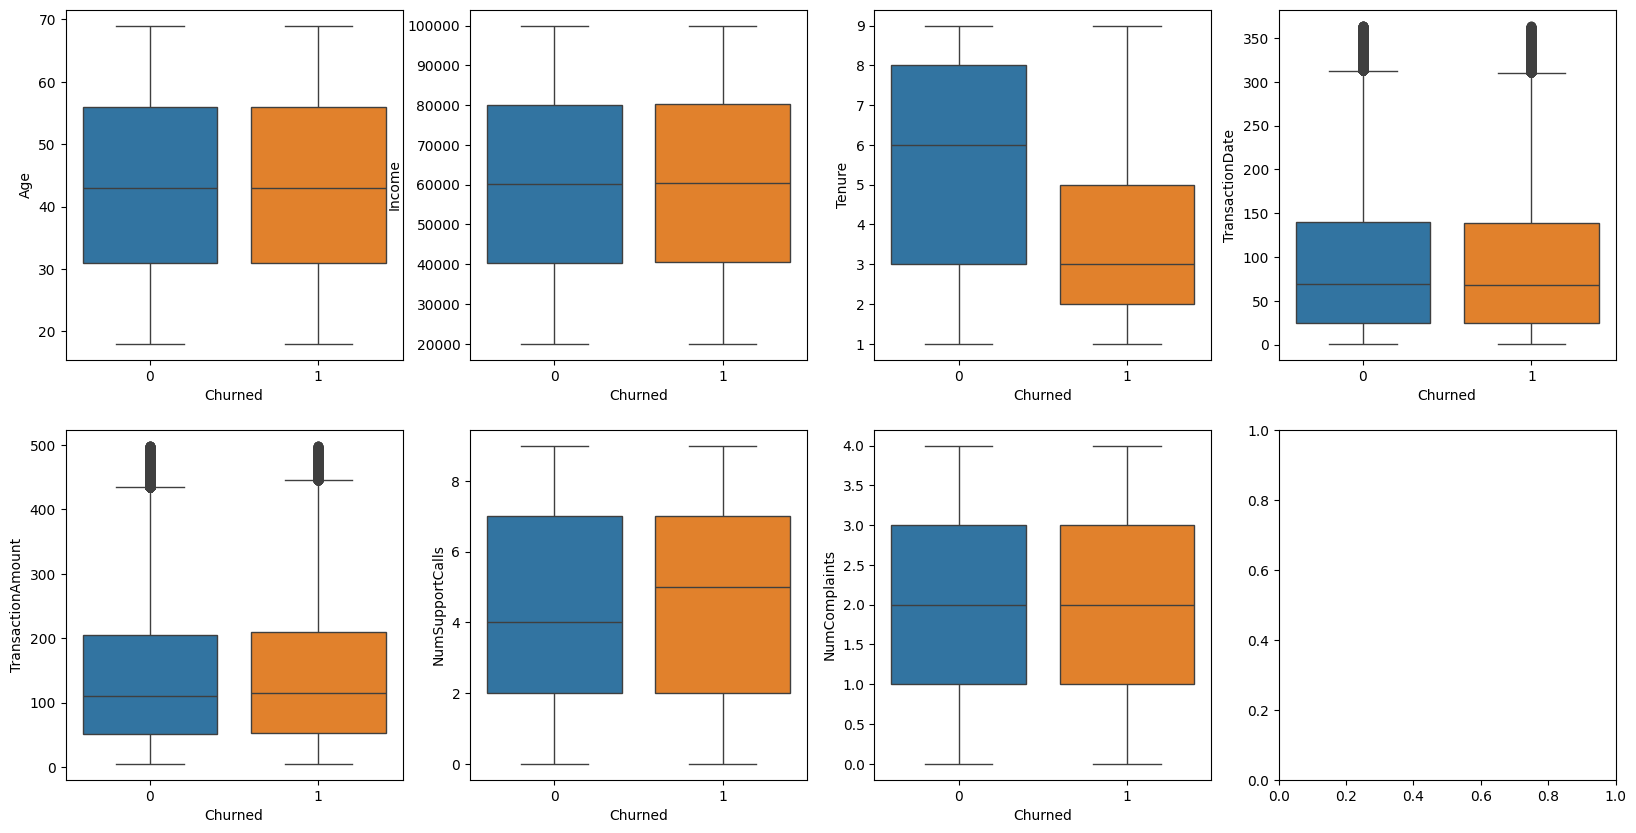

In [6]:
# Visualise Numeric
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
sns.boxplot(data=df_ori, x='Churned', y='Age', hue='Churned', ax=axs[0][0], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='Income', hue='Churned', ax=axs[0][1], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='Tenure', hue='Churned', ax=axs[0][2], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='TransactionDate', hue='Churned', ax=axs[0][3], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='TransactionAmount', hue='Churned', ax=axs[1][0], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='NumSupportCalls', hue='Churned', ax=axs[1][1], legend=False)
sns.boxplot(data=df_ori, x='Churned', y='NumComplaints', hue='Churned', ax=axs[1][2], legend=False)

In [7]:
# Summary statistics for numerical
df_ori.groupby('Churned')[l_cols_num].agg(
    {i: ['mean', 'median', 'var'] for i in l_cols_num}
    )

Age                           Income                         \
              mean median         var          mean   median           var   
Churned                                                                      
0        43.456960   43.0  224.200785  60107.904857  60166.0  5.306357e+08   
1        43.561662   43.0  222.366245  60399.549467  60509.5  5.318075e+08   

           Tenure                  TransactionDate                      \
             mean median       var            mean median          var   
Churned                                                                  
0        5.448671    6.0  6.427297       91.698982   69.0  6459.230270   
1        3.818657    3.0  5.228285       91.459435   68.0  6456.119522   

        TransactionAmount                       NumSupportCalls         \
                     mean  median           var            mean median   
Churned                                                                  
0              138.989482  110.28  11616.327146        4.494869    4.0   
1              142.313321  114.45  11851.579215        4.519040    5.0   

                  NumComplaints                   
              var          mean median       var  
Churned                                           
0        8.237180      1.994917    2.0  1.995106  
1        8.252496      1.995646    2.0  2.001542

In [8]:
# Hypothesis tests
n = 100000
seed = 12345
sl = 0.05
d_test = {'columns': l_cols_num, 'churned': [], 'notchurned':[], 'difference': [], 'pval':[], 'outcome':[]}

for col in l_cols_num:
    l_churned = list(df_ori.loc[df_ori['Churned']==1, col].sample(n=n, random_state=seed))
    l_notchurned = list(df_ori.loc[df_ori['Churned']==0, col].sample(n=n, random_state=seed))

    mean_churned = round(np.mean(l_churned), 2)
    mean_notchurned = round(np.mean(l_notchurned), 2)

    pval = t_test(l_notchurned,l_churned, alternative='both', var=False)

    if pval < sl:
        pval_g = t_test(l_churned,l_notchurned, alternative='greater', var=False)
        if pval_g < sl:
            pval_final = pval_g
            outcome = 'greater'
        else:
            pval_l = t_test(l_churned,l_notchurned, alternative='less', var=False)
            if pval_l < sl:
                pval_final = pval_l
                outcome = 'less'
    else:
        pval_final = pval
        outcome = 'no difference'

    # Store in dict
    d_test['churned'].append(mean_churned)
    d_test['notchurned'].append(mean_notchurned)
    d_test['difference'].append(abs(mean_churned-mean_notchurned))
    d_test['pval'].append(pval_final)
    d_test['outcome'].append(outcome)

pd.DataFrame(d_test)


,columns,churned,notchurned,difference,pval,outcome
0,Age,43.51,43.43,0.08,2.343300e-01,no difference
1,Income,60430.66,60026.61,404.05,4.439562e-05,greater
2,Tenure,3.82,5.45,1.63,0.000000e+00,less
3,TransactionDate,91.55,91.55,0.00,9.992447e-01,no difference
4,TransactionAmount,142.42,139.03,3.39,1.435154e-12,greater
5,NumSupportCalls,4.52,4.49,0.03,7.322292e-03,greater
6,NumComplaints,1.99,2.00,0.01,7.630779e-02,no difference


<Axes: >

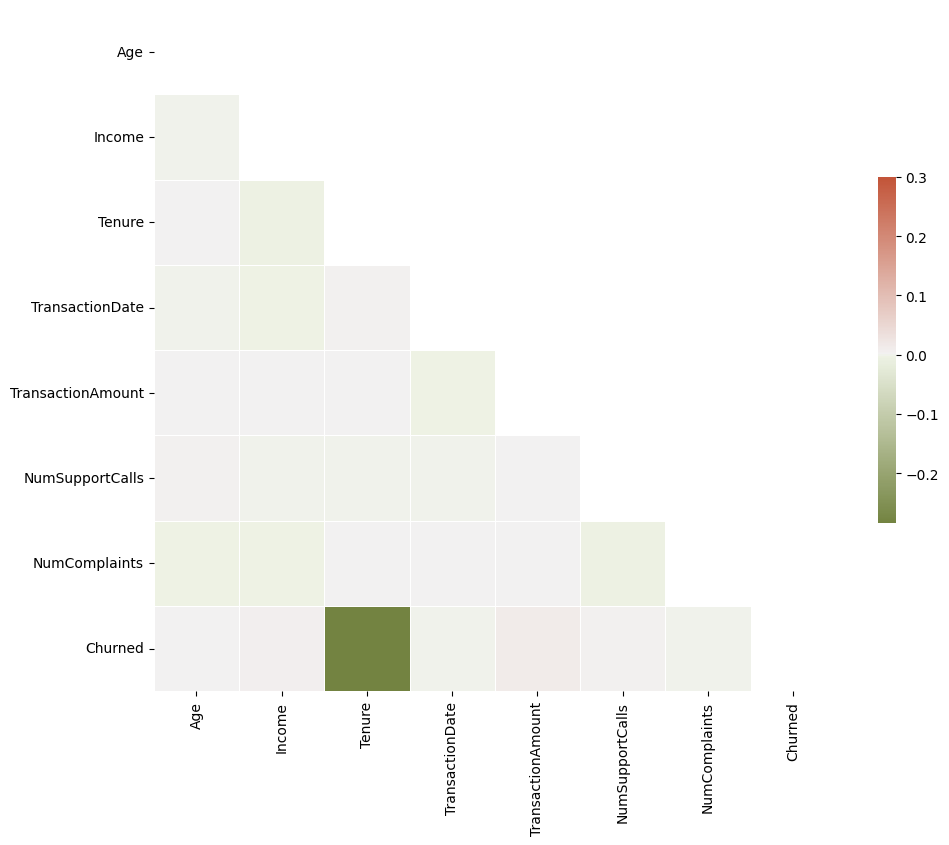

In [9]:
# Correlations
corr = df_ori[l_cols_num + ['Churned']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(100, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: xlabel='NumComplaints', ylabel='Count'>

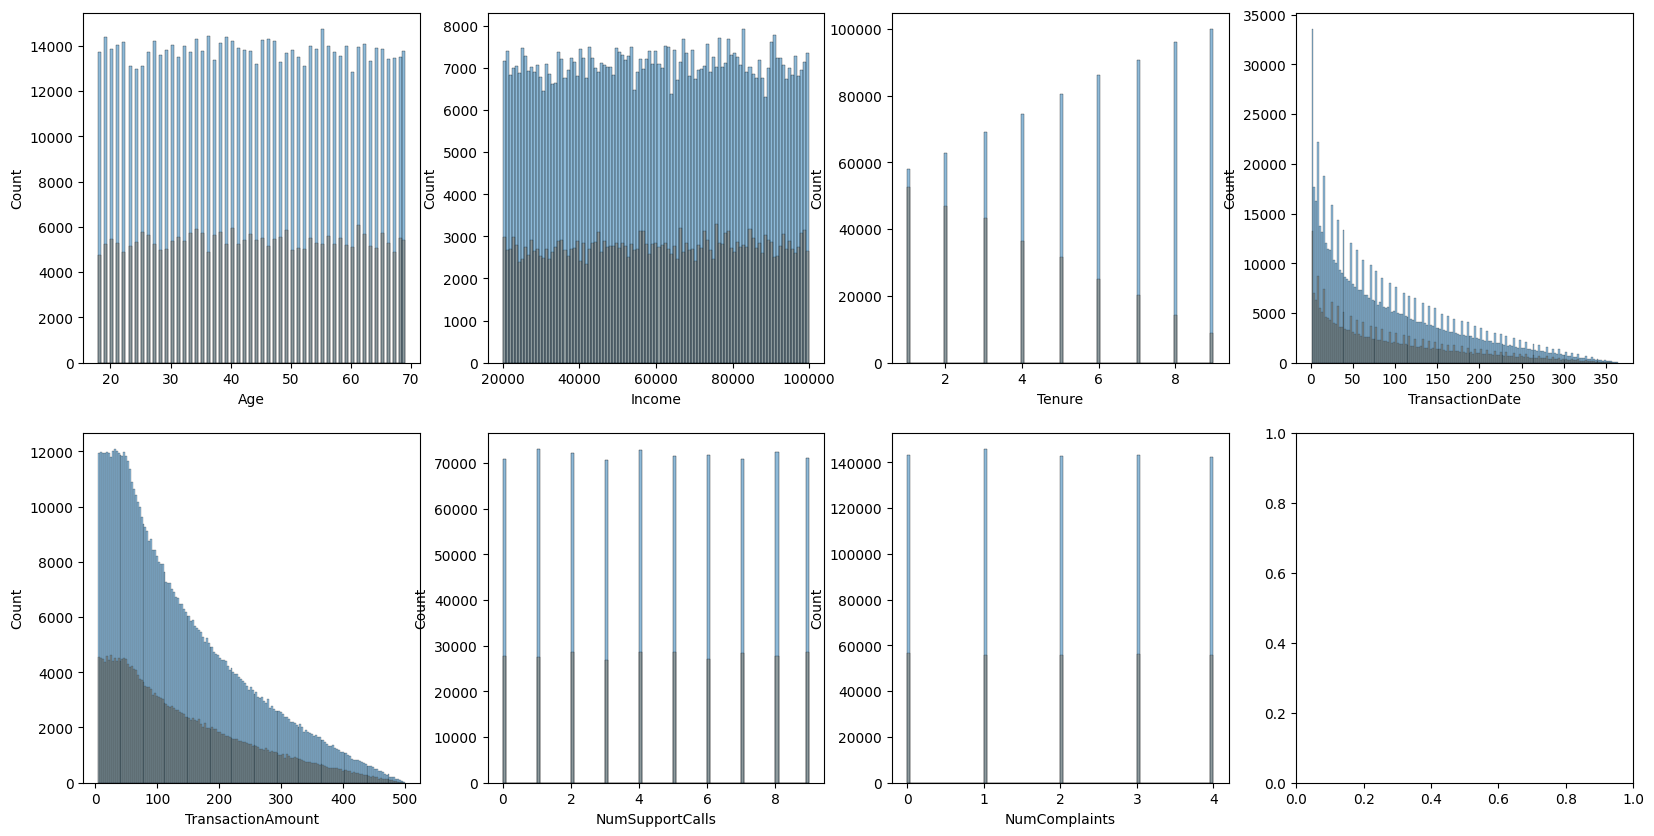

In [10]:
# Numeric Histograms
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
sns.histplot(data=df_ori, x='Age', hue='Churned', ax=axs[0][0], legend=False)
sns.histplot(data=df_ori, x='Income', hue='Churned', ax=axs[0][1], legend=False)
sns.histplot(data=df_ori, x='Tenure', hue='Churned', ax=axs[0][2], legend=False)
sns.histplot(data=df_ori, x='TransactionDate', hue='Churned', ax=axs[0][3], legend=False)
sns.histplot(data=df_ori, x='TransactionAmount', hue='Churned', ax=axs[1][0], legend=False)
sns.histplot(data=df_ori, x='NumSupportCalls', hue='Churned', ax=axs[1][1], legend=False)
sns.histplot(data=df_ori, x='NumComplaints', hue='Churned', ax=axs[1][2], legend=False)

## 3. Pre-Processing

### 3.1. Outliers

In [11]:
df_ori.groupby('Churned')[l_cols_num].agg(
    {i: ['mean', 'min', 'median', 'max'] for i in l_cols_num}
    )

Age                       Income                         \
              mean min median max          mean    min   median    max   
Churned                                                                  
0        43.456960  18   43.0  69  60107.904857  20000  60166.0  99999   
1        43.561662  18   43.0  69  60399.549467  20003  60509.5  99998   

           Tenure                TransactionDate                  \
             mean min median max            mean min median  max   
Churned                                                            
0        5.448671   1    6.0   9       91.698982   1   69.0  364   
1        3.818657   1    3.0   9       91.459435   1   68.0  364   

        TransactionAmount                      NumSupportCalls                 \
                     mean  min  median     max            mean min median max   
Churned                                                                         
0              138.989482  5.0  110.28  498.90        4.494869   0    4.0   9   
1              142.313321  5.0  114.45  498.78        4.519040   0    5.0   9   

        NumComplaints                 
                 mean min median max  
Churned                               
0            1.994917   0    2.0   4  
1            1.995646   0    2.0   4

In [12]:
# Using IQR
df_ori_iqr = df_ori.copy()

for col in l_cols_num:
    Q1 = df_ori[col].quantile(0.25)
    Q3 = df_ori[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = int(Q1 - 1.5*IQR)
    upper = int(Q3 + 1.5*IQR)

    UQ = df_ori.loc[df_ori[col] > upper, col]
    LQ = df_ori.loc[df_ori[col] < lower, col]

    print(f"{col}: UQ({Q3}): {len(UQ)}({round(np.mean(UQ), 2)}) LQ({Q1}): {len(LQ)}({round(np.mean(LQ), 2)})")

    # Replace
    df_ori_iqr.loc[df_ori_iqr[col] > upper, col] = upper
    df_ori_iqr.loc[df_ori_iqr[col] < lower, col] = lower

df_ori_iqr.groupby('Churned')[l_cols_num].agg(
    {i: ['mean', 'min', 'median', 'max'] for i in l_cols_num}
    )

Age: UQ(56.0): 0(nan) LQ(31.0): 0(nan)
Income: UQ(80053.0): 0(nan) LQ(40374.0): 0(nan)
Tenure: UQ(7.0): 0(nan) LQ(3.0): 0(nan)
TransactionDate: UQ(140.0): 10757(329.53) LQ(25.0): 0(nan)
TransactionAmount: UQ(206.13): 9267(457.53) LQ(51.87): 0(nan)
NumSupportCalls: UQ(7.0): 0(nan) LQ(2.0): 0(nan)
NumComplaints: UQ(3.0): 0(nan) LQ(1.0): 0(nan)


Age                       Income                         \
              mean min median max          mean    min   median    max   
Churned                                                                  
0        43.456960  18   43.0  69  60107.904857  20000  60166.0  99999   
1        43.561662  18   43.0  69  60399.549467  20003  60509.5  99998   

           Tenure                TransactionDate                  \
             mean min median max            mean min median  max   
Churned                                                            
0        5.448671   1    6.0   9       91.508351   1   69.0  312   
1        3.818657   1    3.0   9       91.274366   1   68.0  312   

        TransactionAmount                     NumSupportCalls                 \
                     mean  min  median    max            mean min median max   
Churned                                                                        
0              138.800203  5.0  110.28  437.0        4.494869   0    4.0   9   
1              142.118940  5.0  114.45  437.0        4.519040   0    5.0   9   

        NumComplaints                 
                 mean min median max  
Churned                               
0            1.994917   0    2.0   4  
1            1.995646   0    2.0   4

In [13]:
# Using 2SD
df_ori_2sd = df_ori.copy()

for col in l_cols_num:
    mean = df_ori[col].mean()
    sd = df_ori[col].std()
    lower = int(mean - (2*sd))
    upper = int(mean + (2*sd))

    UQ = df_ori.loc[df_ori[col] > upper, col]
    LQ = df_ori.loc[df_ori[col] < lower, col]

    print(f"{col}: +2SD({Q3}): {len(UQ)}({round(np.mean(UQ), 2)}) -2SD({Q1}): {len(LQ)}({round(np.mean(LQ), 2)})")

    # Replace
    df_ori_2sd.loc[df_ori_2sd[col] > upper, col] = upper
    df_ori_2sd.loc[df_ori_2sd[col] < lower, col] = lower

df_ori_2sd.groupby('Churned')[l_cols_num].agg(
    {i: ['mean', 'min', 'median', 'max'] for i in l_cols_num}
    )

Age: +2SD(3.0): 0(nan) -2SD(1.0): 0(nan)
Income: +2SD(3.0): 0(nan) -2SD(1.0): 0(nan)
Tenure: +2SD(3.0): 0(nan) -2SD(1.0): 0(nan)
TransactionDate: +2SD(3.0): 53675(288.6) -2SD(1.0): 0(nan)
TransactionAmount: +2SD(3.0): 51710(402.5) -2SD(1.0): 0(nan)
NumSupportCalls: +2SD(3.0): 0(nan) -2SD(1.0): 0(nan)
NumComplaints: +2SD(3.0): 0(nan) -2SD(1.0): 0(nan)


Age                       Income                         \
              mean min median max          mean    min   median    max   
Churned                                                                  
0        43.456960  18   43.0  69  60107.904857  20000  60166.0  99999   
1        43.561662  18   43.0  69  60399.549467  20003  60509.5  99998   

           Tenure                TransactionDate                  \
             mean min median max            mean min median  max   
Churned                                                            
0        5.448671   1    6.0   9       89.725978   1   69.0  252   
1        3.818657   1    3.0   9       89.499800   1   68.0  252   

        TransactionAmount                     NumSupportCalls                 \
                     mean  min  median    max            mean min median max   
Churned                                                                        
0              136.614014  5.0  110.28  356.0        4.494869   0    4.0   9   
1              139.814753  5.0  114.45  356.0        4.519040   0    5.0   9   

        NumComplaints                 
                 mean min median max  
Churned                               
0            1.994917   0    2.0   4  
1            1.995646   0    2.0   4

In [14]:
# Using 3SD
df_ori_3sd = df_ori.copy()

for col in l_cols_num:
    mean = df_ori[col].mean()
    sd = df_ori[col].std()
    lower = int(mean - (3*sd))
    upper = int(mean + (3*sd))

    UQ = df_ori.loc[df_ori[col] > upper, col]
    LQ = df_ori.loc[df_ori[col] < lower, col]

    print(f"{col}: +3SD({Q3}): {len(UQ)}({round(np.mean(UQ), 2)}) -3SD({Q1}): {len(LQ)}({round(np.mean(LQ), 2)})")

    # Replace
    df_ori_3sd.loc[df_ori_3sd[col] > upper, col] = upper
    df_ori_3sd.loc[df_ori_3sd[col] < lower, col] = lower

df_ori_3sd.groupby('Churned')[l_cols_num].agg(
    {i: ['mean', 'min', 'median', 'max'] for i in l_cols_num}
    )

Age: +3SD(3.0): 0(nan) -3SD(1.0): 0(nan)
Income: +3SD(3.0): 0(nan) -3SD(1.0): 0(nan)
Tenure: +3SD(3.0): 0(nan) -3SD(1.0): 0(nan)
TransactionDate: +3SD(3.0): 3938(343.1) -3SD(1.0): 0(nan)
TransactionAmount: +3SD(3.0): 2921(475.79) -3SD(1.0): 0(nan)
NumSupportCalls: +3SD(3.0): 0(nan) -3SD(1.0): 0(nan)
NumComplaints: +3SD(3.0): 0(nan) -3SD(1.0): 0(nan)


Age                       Income                         \
              mean min median max          mean    min   median    max   
Churned                                                                  
0        43.456960  18   43.0  69  60107.904857  20000  60166.0  99999   
1        43.561662  18   43.0  69  60399.549467  20003  60509.5  99998   

           Tenure                TransactionDate                  \
             mean min median max            mean min median  max   
Churned                                                            
0        5.448671   1    6.0   9       91.654287   1   69.0  332   
1        3.818657   1    3.0   9       91.417851   1   68.0  332   

        TransactionAmount                     NumSupportCalls                 \
                     mean  min  median    max            mean min median max   
Churned                                                                        
0              138.955211  5.0  110.28  464.0        4.494869   0    4.0   9   
1              142.278147  5.0  114.45  464.0        4.519040   0    5.0   9   

        NumComplaints                 
                 mean min median max  
Churned                               
0            1.994917   0    2.0   4  
1            1.995646   0    2.0   4

## 4. Export

In [15]:
# Choose 3sd as it has the most spread - outliers not significantly different by churn
df_ori_3sd['TransactionAmount'] = df_ori_3sd['TransactionAmount'].astype(float)
df_ori_3sd.head()

,Age,Gender,Income,Tenure,Location,TransactionDate,TransactionType,TransactionAmount,NumSupportCalls,NumComplaints,Churned
0,56,Female,91512,4,Urban,17,Support Fee,147.70,2,3,0
1,56,Female,91512,4,Urban,19,Support Fee,90.61,2,3,0
2,56,Female,91512,4,Urban,11,Purchase,180.82,2,3,0
3,56,Female,91512,4,Urban,4,Refund,115.54,2,3,0
4,56,Female,91512,4,Urban,15,Subscription Renewal,36.45,2,3,0


In [16]:
df_ori_3sd.to_csv(fr"{dataout}//{dataset}_EDA.csv", index=False)